<a href="https://colab.research.google.com/github/dsaldana/reinforcement-learning-course/blob/main/lab11_MBRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 11: Solving the mountaincar problem in 1 episode

In this lab, you will use a Gaussian Process (GP) model to learn the dynamics of the Mountain Car system.
Then, based on Lab 8, you will use MPPI or MPPI-Simplified to write the MPC loop that controls the vehicle.
The goal is to solve the Mountain Car problem in one episode.

## Provided code
* The following code implements a Gaussian Process regression model that predicts the next-state change (Δx) given [position, velocity, action].
* Example training data collected from random actions.



In [1]:
# %matplotlib widget
%matplotlib inline

In [3]:
!pip install gpytorch
!pip install gymnasium


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Gaussian Process

In [4]:
import torch
import gpytorch
import numpy as np

# ============================================================
# ---- Base Exact GP model -------------------
# ============================================================

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel='RBF', ard_dims=None):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        # Choose kernel type
        if kernel == 'RBF':
            base_kernel = gpytorch.kernels.RBFKernel(ard_num_dims=ard_dims)
        elif kernel == 'Matern':
            base_kernel = gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=ard_dims)
        elif kernel == 'RQ':
            base_kernel = gpytorch.kernels.RationalQuadraticKernel(ard_num_dims=ard_dims)
        else:
            raise ValueError(f"Unsupported kernel type: {kernel}")

        self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# ============================================================
# ---- Individual GP Manager: handles data + normalization ----
# ============================================================

class GPManager:
    def __init__(self, kernel='RBF', lr=0.03, iters=1000):
        self.kernel = kernel
        self.lr = lr
        self.iters = iters
        self.trained = False
        self.X_train = []
        self.Y_train = []

        self.likelihood = None
        self.model = None


    # ----------------------------- #
    #        FIT / INITIAL TRAIN    #
    # ----------------------------- #
    def fit(self, X, Y):
        X = torch.tensor(X, dtype=torch.float32)
        Y = torch.tensor(Y, dtype=torch.float32)

        self.X_train = X.clone()
        self.Y_train = Y.clone()

        self.retrain()

    def retrain(self):
        # Normalize the input/output and then train the model
        self._compute_normalization()
        self._train_model()

    # ----------------------------- #
    #       ADD NEW DATA POINTS     #
    # ----------------------------- #
    def add_data(self, X_new, Y_new, retrain=True):
        """
        Add new data (single or batch) to GP training set.
        Optionally retrain the model.
        """
        X_new = torch.tensor(X_new, dtype=torch.float32)
        Y_new = torch.tensor(Y_new, dtype=torch.float32).flatten()  # ensure 1D

        # Also flatten stored Y to ensure shape consistency
        if self.Y_train.ndim > 1:
            self.Y_train = self.Y_train.flatten()

        # Append new data
        self.X_train = torch.cat([self.X_train, X_new], dim=0)
        self.Y_train = torch.cat([self.Y_train, Y_new], dim=0)

        if retrain:
            self.retrain()

    # ----------------------------- #
    #         INTERNAL UTILS        #
    # ----------------------------- #
    def _compute_normalization(self):
        self.X_mean, self.X_std = self.X_train.mean(0), self.X_train.std(0)
        self.Y_mean, self.Y_std = float(self.Y_train.mean(0)), float(self.Y_train.std(0))

        Xn = (self.X_train - self.X_mean) / self.X_std
        Yn = (self.Y_train - self.Y_mean) / self.Y_std

        self.Xn, self.Yn = Xn, Yn

    def dataset(self):
        # Extract training data (already stored inside the wrapper)
        X_train = self.X_train.numpy()
        Y_train = self.Y_train.numpy()
        return X_train, Y_train


    def _train_model(self):
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()
        self.likelihood.noise_covar.initialize(noise=1e-3)
        self.model = ExactGPModel(self.Xn, self.Yn, self.likelihood,
                                  kernel=self.kernel, ard_dims=self.X_train.shape[-1])

        # -------------------------------------------------
        # Train the model
        # -------------------------------------------------
        self.train_gp(self.model, self.likelihood, self.Xn, self.Yn)
        self.trained = True

    def train_gp(self, model, likelihood, x, y):
        model.train(); likelihood.train()
        opt = torch.optim.Adam(model.parameters(), lr=self.lr)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
        for _ in range(self.iters):
            opt.zero_grad()
            out = model(x)
            loss = -mll(out, y)
            loss.backward()
            opt.step()
        model.eval(); likelihood.eval()

    def predict(self, X):
        if not self.trained:
            raise RuntimeError("GP has not been trained yet.")

        # Normalize the input
        X = torch.as_tensor(X, dtype=torch.float32)
        Xn = (X - self.X_mean) / self.X_std
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            pred = self.likelihood(self.model(Xn))

            # Unonormalize the output
            mean = pred.mean.cpu().numpy() * self.Y_std + self.Y_mean
            var = pred.variance.cpu().numpy() * (self.Y_std ** 2)
        # Return the unnormalized output
        return mean, var


# Setup environment and collect initial data

In [5]:
import gymnasium as gym
# import gym
import numpy as np
import torch
import matplotlib.pyplot as plt

# --------------------------------------------------------------
# 1.  Environment setup
# --------------------------------------------------------------
env = gym.make("MountainCarContinuous-v0", max_episode_steps=500)
n_state = env.observation_space.shape[0]    # [position, velocity]
n_action = env.action_space.shape[0]        # 1 continuous action
n_output = 2                                # Δpos, Δvel


# --------------------------------------------------------------
# 2.  Collect initial random data
# --------------------------------------------------------------
data = {'X': [], 'Y': []}

obs, _ = env.reset(seed=0)
for _ in range(200):  # collect 500 transitions
    a = env.action_space.sample()  # random continuous action in [-1,1]
    x_next, r, term, trunc, _ = env.step(a)
    data['X'].append(np.concatenate([obs, a]))   # [pos, vel, action]
    data['Y'].append(x_next - obs)               # Δstate
    obs = x_next
    if term or trunc:
        obs, _ = env.reset()

X = np.array(data['X'])[::3]
Y = np.array(data['Y'])[::3]
print(f"Collected {len(X)} transitions.")


# --------------------------------------------------------------
# 3.  Train GP dynamics models
# --------------------------------------------------------------
gps = [GPManager(kernel='RBF', iters=300) for _ in range(n_output)]

for d in range(n_output):
    gps[d].fit(X, Y[:, d])
    print(f"Trained GP for Δstate[{d}] with {len(X)} samples.")


Collected 67 transitions.
Trained GP for Δstate[0] with 67 samples.
Trained GP for Δstate[1] with 67 samples.


# Visualize collected data

Plotting for action a=-1.0
Values near action a=-1.0 n=16


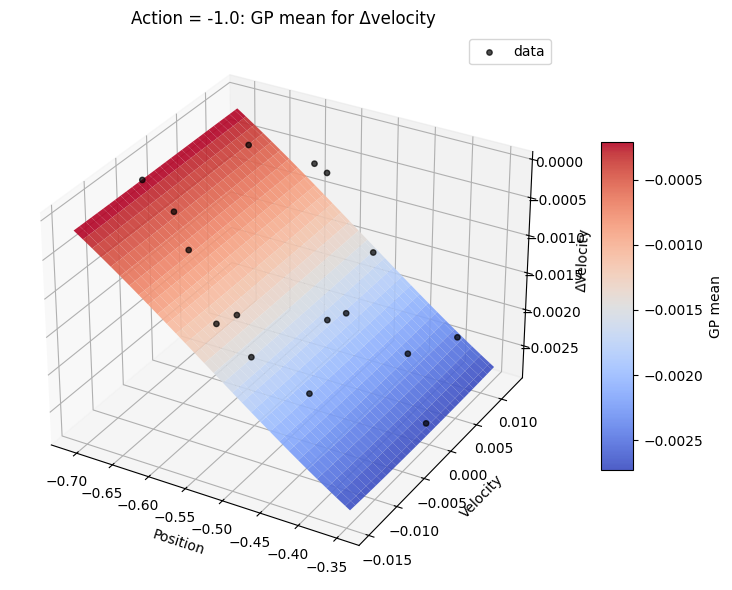

Plotting for action a=0.0
Values near action a=0.0 n=37


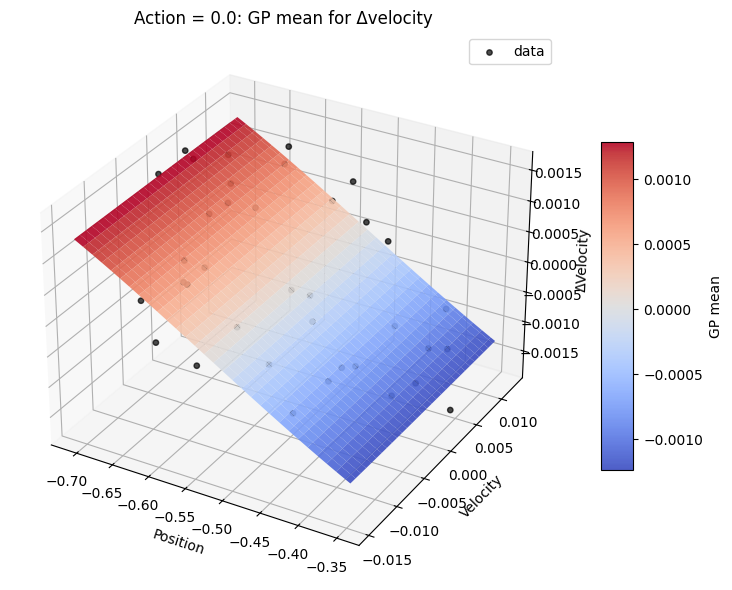

Plotting for action a=1.0
Values near action a=1.0 n=14


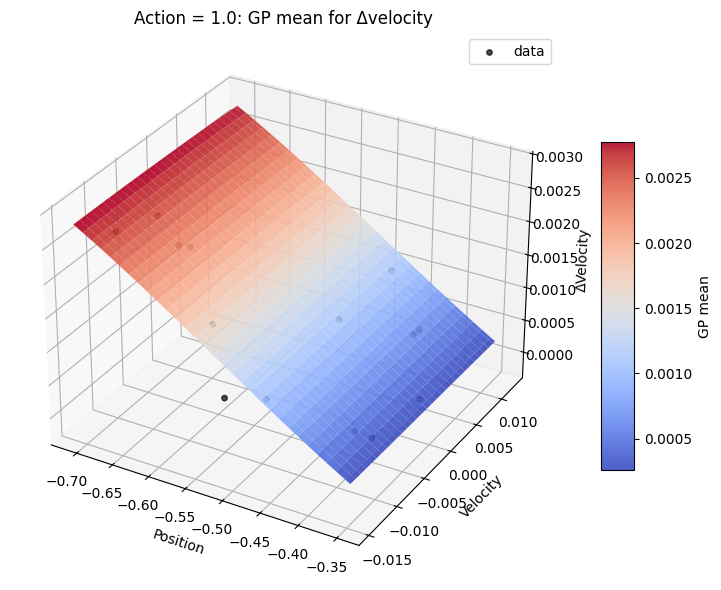

In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# --------------------------------------------------------
# Visualization setup
# --------------------------------------------------------
gp = gps[1]   # GP for Δvelocity
a_values = [-1.0, 0.0, 1.0]  # representative actions

# Get raw training data
X_train, Y_train = gp.dataset()
pos, vel, act = X_train[:, 0], X_train[:, 1], X_train[:, 2]
dvel = Y_train  # Δvelocity targets

# --------------------------------------------------------
# Define grid for visualization
# --------------------------------------------------------
p_min, p_max = pos.min(), pos.max()
v_min, v_max = vel.min(), vel.max()

p_grid = np.linspace(p_min, p_max, 60)
v_grid = np.linspace(v_min, v_max, 60)
P, V = np.meshgrid(p_grid, v_grid)

# --------------------------------------------------------
# Generate and plot for each action
# --------------------------------------------------------
for a_fixed in a_values:
    print(f"Plotting for action a={a_fixed}")

    # Predict using the GP for this action
    X_grid = np.column_stack([P.ravel(), V.ravel(), np.full_like(P.ravel(), a_fixed)])
    Mean, var = gp.predict(X_grid)
    Mean = Mean.reshape(P.shape)

    # --------------------------------------------------------
    # Plot as surface
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(P, V, Mean, cmap='coolwarm',
                           linewidth=0, antialiased=True, alpha=0.9)

    # Overlay training data close to this action value
    mask = np.abs(act - a_fixed) < 0.5
    print(f"Values near action a={a_fixed} n={np.sum(mask)}")
    ax.scatter(pos[mask], vel[mask], dvel[mask],
               color='k', s=15, alpha=0.7, label='data')

    # --------------------------------------------------------
    # Labels and title
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('ΔVelocity')
    ax.set_title(f"Action = {a_fixed:.1f}: GP mean for Δvelocity")

    fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10, label='GP mean')
    ax.legend()
    plt.tight_layout()
    plt.show()


Values near action a=-1.0 → n=18


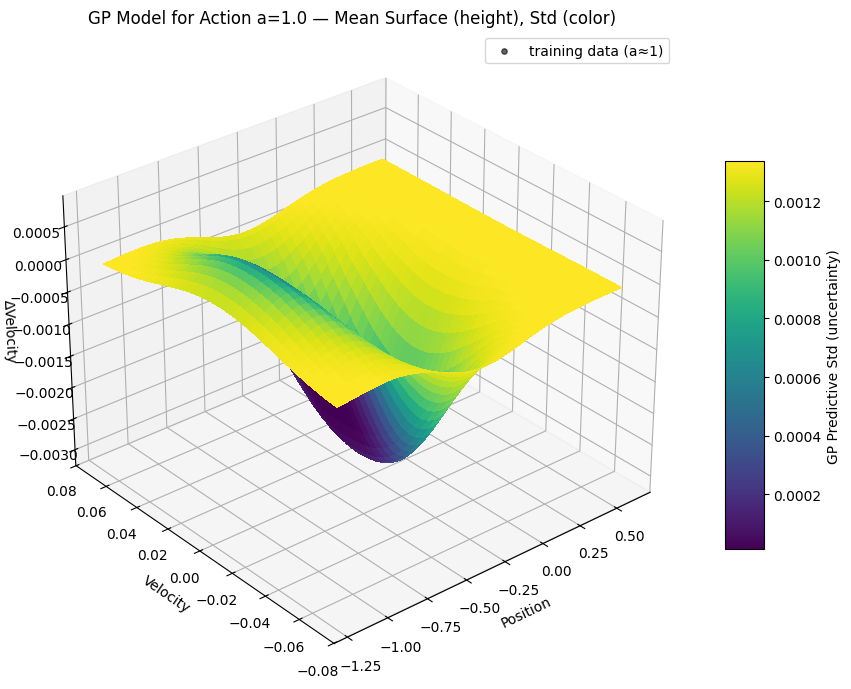

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --------------------------------------------------------
# Choose which GP to visualize
# --------------------------------------------------------
gp = gps[1]   # GP for Δvelocity (index 0 for Δposition)
a_fixed = -1.0 # fixed continuous action (maximum thrust)

# --------------------------------------------------------
# Get training data
# --------------------------------------------------------
X_train, Y_train = gp.dataset()
pos, vel, act = X_train[:, 0], X_train[:, 1], X_train[:, 2]
dvel = Y_train

# Select samples close to a=1 for overlay
mask = np.abs(act - a_fixed) < 0.5
print(f"Values near action a={a_fixed} → n={np.sum(mask)}")

# --------------------------------------------------------
# Define position–velocity grid
# --------------------------------------------------------
p_min, p_max = -1.2, 0.6
v_min, v_max = -0.07, 0.07
p_grid = np.linspace(p_min, p_max, 80)
v_grid = np.linspace(v_min, v_max, 80)
P, V = np.meshgrid(p_grid, v_grid)

# Query points for the fixed action
X_grid = np.column_stack([P.ravel(), V.ravel(), np.full_like(P.ravel(), a_fixed)])

# --------------------------------------------------------
# GP predictions
# --------------------------------------------------------
Mean, Var = gp.predict(X_grid)
Mean = Mean.reshape(P.shape)
Std = np.sqrt(Var.reshape(P.shape))

# Normalize Std for color mapping
norm = plt.Normalize(vmin=Std.min(), vmax=Std.max())
colors = plt.cm.viridis(norm(Std))

# --------------------------------------------------------
# Plot surface: Mean as height, Std as color
# --------------------------------------------------------
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    P, V, Mean,
    facecolors=colors, linewidth=0, antialiased=False, shade=False
)

# Colorbar = predictive uncertainty
m = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
m.set_array(Std)
cbar = fig.colorbar(m, ax=ax, shrink=0.6, aspect=10)
cbar.set_label('GP Predictive Std (uncertainty)')

# Overlay raw data (samples with similar a)
ax.scatter(
    pos[mask], vel[mask], dvel[mask],
    color='k', s=15, alpha=0.6, label='training data (a≈1)'
)

# --------------------------------------------------------
# Labels and title
# --------------------------------------------------------
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_zlabel('ΔVelocity')
ax.set_title("GP Model for Action a=1.0 — Mean Surface (height), Std (color)")
ax.view_init(elev=30, azim=230)
ax.legend()
plt.tight_layout()
plt.show()


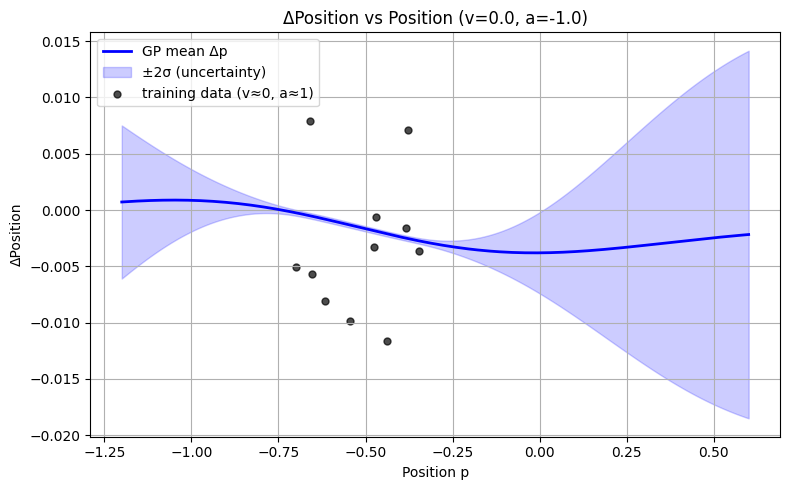

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------
# Choose GP: Δposition model
# --------------------------------------------------------
gp = gps[0]       # GP for Δposition
v_fixed = 0.0     # fix velocity
a_fixed = -1.0     # fix action

# --------------------------------------------------------
# Define position grid
# --------------------------------------------------------
p_min, p_max = -1.2, 0.6
p_grid = np.linspace(p_min, p_max, 200)

# Construct query points [p, v_fixed, a_fixed]
X_query = np.column_stack([p_grid, np.full_like(p_grid, v_fixed), np.full_like(p_grid, a_fixed)])

# --------------------------------------------------------
# Predict GP mean and std
# --------------------------------------------------------
Mean, Var = gp.predict(X_query)
Std = np.sqrt(Var)

# --------------------------------------------------------
# Plot mean ± std as shaded region
# --------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(p_grid, Mean, 'b-', lw=2, label='GP mean Δp')
plt.fill_between(p_grid, Mean - 2*Std, Mean + 2*Std,
                 color='blue', alpha=0.2, label='±2σ (uncertainty)')

# --------------------------------------------------------
# Overlay training data near v=0 and a=1
# --------------------------------------------------------
X_train, Y_train = gp.dataset()
mask = (np.abs(X_train[:, 1] - v_fixed) < 0.01) & (np.abs(X_train[:, 2] - a_fixed) < 0.5)
plt.scatter(X_train[mask, 0], Y_train[mask], color='k', s=25, alpha=0.7, label='training data (v≈0, a≈1)')

# --------------------------------------------------------
# Labels and title
# --------------------------------------------------------
plt.xlabel("Position p")
plt.ylabel("ΔPosition")
plt.title(f"ΔPosition vs Position (v={v_fixed}, a={a_fixed})")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Exercise 1
Use the trained GP as a learned dynamics model to control the Mountain Car environment using Model Predictive Control (MPC).

You can choose between:
* MPPI (Model Predictive Path Integral) – probabilistic trajectory weighting, or
* MPPI-Simplified (Random Shooting) – select the lowest-cost trajectory among random samples.

Your controller should plan ahead, predict future states using the GP, and drive the car to reach the goal in a single episode.

### Expected Outcome
By the end of the exercise, your controller should:
* Use the GP model to predict the system dynamics
* Plan and select optimal actions using MPC
* Drive the car to reach the goal in one episode

### Deliverables

* Your implementation of the mpc_action() function
* A plot showing the car’s position versus time
* A short explanation (2–3 sentences) describing how MBRL is more efficient than Q-learning.
* Describe the downside of MBRL over Q-learning

# MPC


In [8]:
def mountain_car_dynamics(p, v, a):
    """
    One-step GP-based dynamics model for MountainCar.
    Inputs:
        p : position (float)
        v : velocity (float)
        a : action (float)
    Returns:
        np.array([p_next, v_next])
    """
    # shape (1, 3): [position, velocity, action]
    inp = np.array([[float(p), float(v), float(a)]], dtype=np.float64)

    # GP 0 -> Δp, GP 1 -> Δv
    dpos_mean, _ = gps[0].predict(inp)
    dvel_mean, _ = gps[1].predict(inp)

    p_next = p + dpos_mean[0]
    v_next = v + dvel_mean[0]

    return np.array([p_next, v_next], dtype=np.float64)


# quick sanity check
predicted_next_state = mountain_car_dynamics(p=-0.5, v=0.0, a=1.0)
print("Predicted next state:", predicted_next_state)


Predicted next state: [-0.49867675  0.0013229 ]


In [9]:
def cost_fn(state, a):
    """
    Cost function for MPC with GP dynamics.
    Encourages being near the goal position and having useful velocity.
    """
    x, v = state
    goal_pos = 0.5

    # distance from goal
    dist = goal_pos - x

    # main term: penalize being far from the goal
    pos_cost = dist ** 2

    # bonus/penalty tied to velocity (large |v| reduces cost magnitude here)
    vel_term = -800.0 * np.abs(v)

    # total cost (you can tune constants if needed)
    return pos_cost + vel_term


In [10]:
def roll_out_trajectory(s0, action_seq, gamma=1.0):
    """
    Roll out a single trajectory using the GP dynamics model.
    Inputs:
        s0 : initial state [p, v]
        action_seq : sequence of actions of length H
        gamma : discount factor
    Returns:
        traj : array of predicted states
        total_cost : accumulated discounted cost
    """
    H = len(action_seq)
    traj = [s0.copy()]
    s = s0.copy()
    disc = 1.0
    total_cost = 0.0

    for t in range(H):
        a = action_seq[t]

        # predict next state via GP model
        s = mountain_car_dynamics(s[0], s[1], a)
        traj.append(s.copy())

        # accumulate cost
        total_cost += cost_fn(s, a) * disc
        disc *= gamma

    return np.array(traj), total_cost


In [11]:
def roll_out_n_trajectories(state, U):
    """
    Roll out a batch of trajectories given an initial state and
    a collection of action sequences U.

    Inputs:
        state : initial state [p, v]
        U     : array-like of shape (N_seq, H) with action sequences

    Returns:
        all_traj : list of trajectories (each is array of states)
        J        : np.array of total costs for each sequence
    """
    N_seq = len(U)
    J = np.zeros(N_seq, dtype=np.float64)
    all_traj = []

    for i in range(N_seq):
        traj_i, cost_i = roll_out_trajectory(state, U[i])
        all_traj.append(traj_i)
        J[i] = cost_i

    return all_traj, J


# quick test with a zero action sequence
Ui = np.zeros(3, dtype=np.float64)
traj, J = roll_out_trajectory(np.array([-0.5, 0.0]), Ui)
traj


array([[-5.00000000e-01,  0.00000000e+00],
       [-5.00176710e-01, -1.76595000e-04],
       [-5.00528549e-01, -3.51943396e-04],
       [-5.01052935e-01, -5.24739735e-04]])

In [12]:
def plot_trajectories(state, best_traj):
    """
    Plot a set of predicted trajectories in (position, velocity) space.
    """
    plt.figure(figsize=(8, 6))

    for idx, traj in enumerate(best_traj):
        pos = traj[:, 0]
        vel = traj[:, 1]
        plt.plot(pos, vel, linewidth=2, alpha=0.8, label=f"Traj {idx + 1}")

    # starting state
    plt.scatter(state[0], state[1], c="red", s=60, zorder=5, label="Start")

    # goal position line
    plt.axvline(0.5, color="gray", linestyle="--", label="Goal position")

    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title("Predicted Trajectories (MPC with GP)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


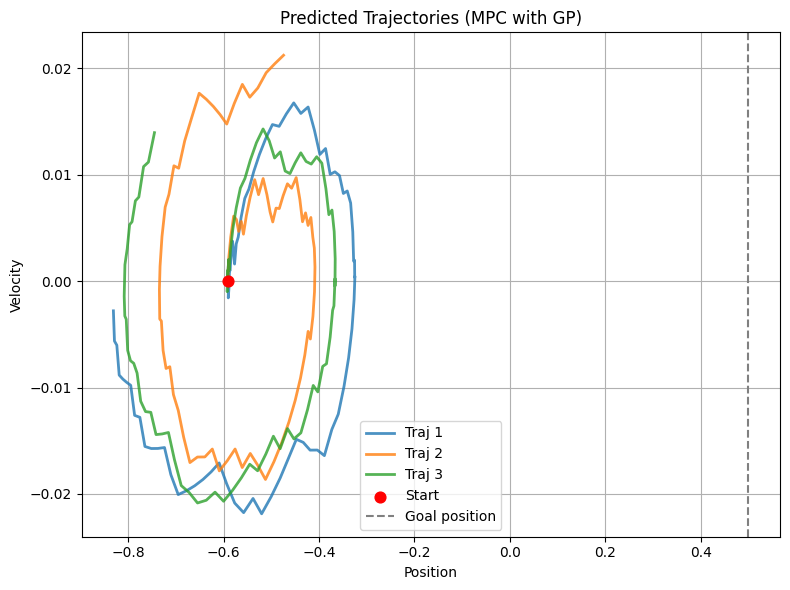

1.0

In [13]:
import numpy as np
import matplotlib.pyplot as plt

class MPPIController:
    def __init__(self, H=100, N_seq=200, λ=1.0, σ=0.3):
        """
        Model Predictive Path Integral (simplified) controller with
        a persistent action sequence used as a warm start.
        """
        self.H = H
        self.N_seq = N_seq
        self.λ = λ
        self.σ = σ

        # mean action sequence that we keep updating
        self.U_mean = np.zeros(H, dtype=np.float64)

    def action(self, state, plot=False, plot_best=3):
        H, N_seq, sigma = self.H, self.N_seq, self.σ

        # 0. Shift the previous mean sequence (move everything one step earlier)
        self.U_mean = np.roll(self.U_mean, -1)
        self.U_mean[-1] = 0.0

        # 1. Sample action sequences (Gaussian noise around U_mean)
        noise = np.random.normal(loc=0.0, scale=sigma, size=(N_seq, H))
        seqs = self.U_mean[None, :] + noise
        seqs = np.clip(seqs, -1.0, 1.0)

        # 2. Roll out trajectories under the GP dynamics
        all_traj, costs = roll_out_n_trajectories(state, seqs)

        # 3. Pick the sequence with the lowest cost and update U_mean
        best_idx = int(np.argmin(costs))
        best_seq = seqs[best_idx].copy()
        self.U_mean = best_seq

        # optional plotting of top-k trajectories
        if plot:
            k = max(1, min(plot_best, N_seq))
            top_idx = np.argsort(costs)[:k]
            best_traj = [all_traj[i] for i in top_idx]
            plot_trajectories(state, best_traj)

        # 4. Return the first action of the chosen sequence
        return float(best_seq[0])


# Initialize controller once
mppi = MPPIController(H=80, N_seq=150, λ=1.0, σ=2.1)

obs, _ = env.reset()
a = mppi.action(obs, plot=True, plot_best=3)  # plot first iteration only
a


Step   0 | state = [-0.47260767  0.        ], action =  0.3224
Step  10 | state = [-0.5384159  -0.01255198], action = -0.6964
Step  20 | state = [-0.70831054 -0.01954108], action = -1.0000
Step  30 | state = [-0.8441143  -0.00244557], action =  0.5368
Step  40 | state = [-0.6904853   0.02956436], action =  0.9285
Step  50 | state = [-0.2922451   0.04386788], action =  1.0000
Step  60 | state = [0.11243795 0.03599824], action =  1.0000
Step  70 | state = [0.4477381  0.03410193], action =  1.0000
Episode finished after 71 steps.
Total steps used: 70


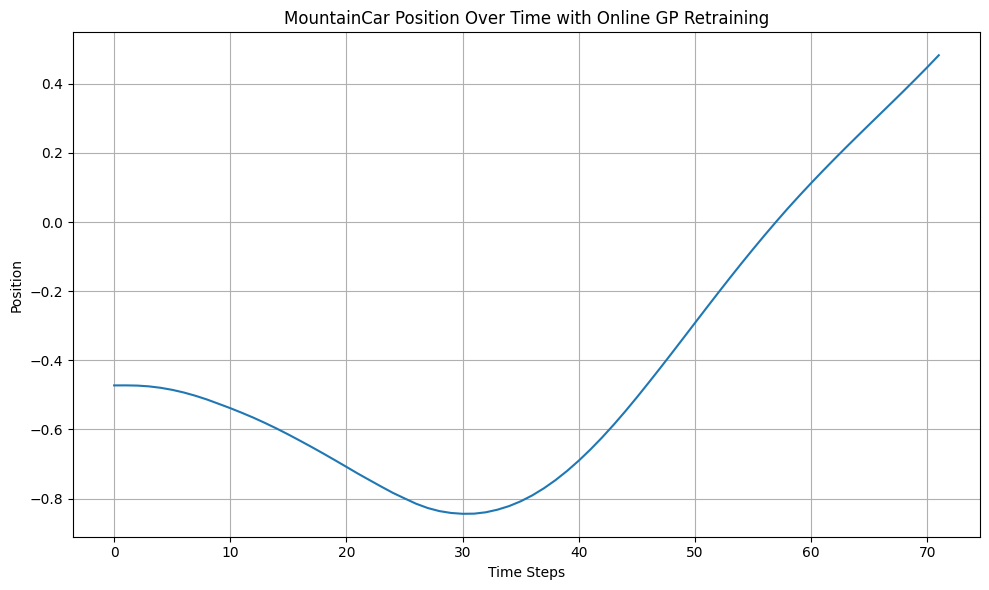

In [14]:
# Initialize controller once
mppi = MPPIController(H=30, N_seq=200, λ=0.10, σ=0.50)

obs, _ = env.reset(seed=0)
traj = []
positions = [obs[0]]  # track position for time-series plot

for t in range(500):
    # 1. Choose action via MPC+GP
    a = mppi.action(obs)
    traj.append([obs.copy(), a])

    if t % 10 == 0:
        print(f"Step {t:3d} | state = {obs}, action = {a: .4f}")

    # 2. Apply action in the real environment
    next_obs, r, term, trunc, _ = env.step([a])

    # 3. Compute observed state change
    delta_obs = next_obs - obs

    # 4. Add this transition to both GP models and retrain
    # GP input: [position, velocity, action]
    X_new = np.concatenate([obs, [a]], axis=0).reshape(1, -1)
    Y_new = delta_obs.reshape(1, -1)

    # Δposition GP
    gps[0].add_data(X_new, Y_new[:, 0], retrain=True)
    # Δvelocity GP
    gps[1].add_data(X_new, Y_new[:, 1], retrain=True)

    # 5. Move to next state
    obs = next_obs
    positions.append(obs[0])

    if term or trunc:
        print(f"Episode finished after {t + 1} steps.")
        break

print(f"Total steps used: {t:.0f}")

# --------------------------------------------------------------
# Plot position vs time
# --------------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(positions)
plt.xlabel("Time Steps")
plt.ylabel("Position")
plt.title("MountainCar Position Over Time with Online GP Retraining")
plt.grid(True)
plt.tight_layout()
plt.show()


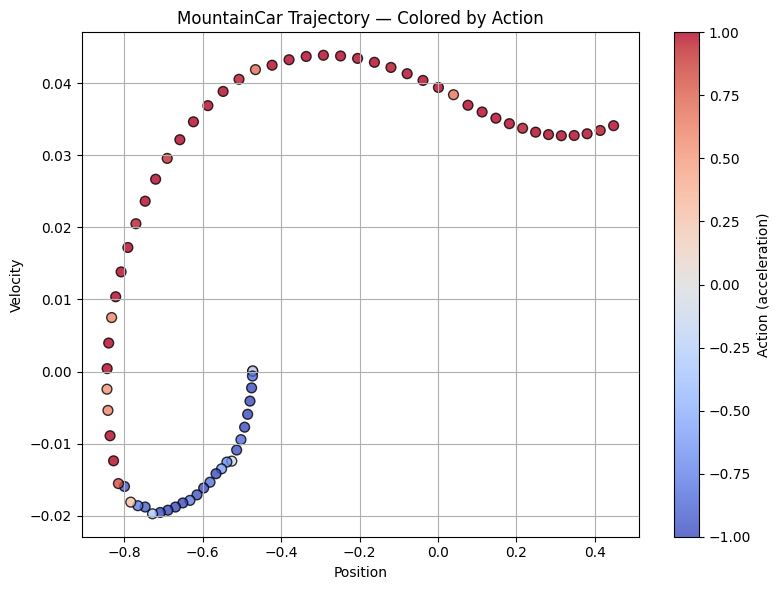

In [15]:
# trajectory is a list of [obs, a]
# each obs is [pos, vel]

def plot_trajectory(trajectory):
    positions, velocities, actions = [], [], []

    for obs, a in trajectory:
        positions.append(obs[0])
        velocities.append(obs[1])
        actions.append(float(a))  # ensure scalar

    positions = np.array(positions)
    velocities = np.array(velocities)
    actions = np.array(actions)

    # --------------------------------------------------------------
    # Scatter plot: position vs velocity, colored by action
    # --------------------------------------------------------------
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(
        positions,
        velocities,
        c=actions,
        cmap="coolwarm",
        s=50,
        edgecolor="k",
        alpha=0.8,
    )

    plt.colorbar(sc, label="Action (acceleration)")
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title("MountainCar Trajectory — Colored by Action")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_trajectory(traj)


### **Why MBRL is more efficient than Q-learning**
Model-Based Reinforcement Learning is more sample-efficient because it learns a dynamics model and can simulate thousands of “virtual” transitions internally instead of needing to experience everything through the real environment. Once the model is accurate, the controller can plan several steps into the future using MPC, which dramatically reduces the number of real interactions needed to reach the goal. In contrast, Q-learning must physically explore state–action pairs many times, making it much slower and less data-efficient.



# Exercise 2 (Graduate students)
Extend the MPC controller from Exercise 1 by incorporating Gaussian Process (GP) uncertainty into the MPPI algorithm.
The goal is to study how including the GP’s predictive variance affects control performance and sample efficiency.


* Include GP uncertainty (variance) in the MPPI algorithm.
Modify the cost function or trajectory weighting so that trajectories passing through regions of high model uncertainty are penalized.

* Compare two systems:
  * MPPI using only the GP mean prediction (deterministic model).
  * MPPI using both the GP mean and variance (uncertainty-aware model).
* Evaluate and discuss the results:
  * The MBRL system from Exercise 1 usually solves the Mountain Car problem in more than 100 steps, even after several episodes.
  * Investigate whether incorporating uncertainty can help the controller reach the goal faster or with fewer samples.
  * Provide plots of position over time for both cases.

## Deliverables

* Your modified MPPI implementation that includes GP variance.
* Two plots comparing:
    * Position vs. time (with and without variance)
    * Cumulative reward or number of steps to reach the goal
* A short discussion (2–3 paragraphs) explaining how including uncertainty affects performance and why it might lead to better results.